# Lights model tutorial

In [1]:
%reset -f
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from tick.plot import plot_point_process
from lights.simulation import SimuJointLongitudinalSurvival
from lights.base.utils import heatmap, annotate_heatmap, gompertz_pdf, \
                              gompertz_survival, visualize_vect_learning, visualize_vect_per_group
from lights.base.base import feat_representation_extraction
from sklearn.model_selection import ShuffleSplit
from lifelines.utils import concordance_index as c_index_score
from IPython.display import Markdown, display
from scipy.stats import beta
from matplotlib import rc
from plotly import graph_objects as go
#rc('text', usetex=True)
%matplotlib inline

def printmd(string):
    display(Markdown(string))

## Generate data

In [2]:
n_long_features = 5
n_time_indep_features = 10
sparsity=0.5
gap = 1.
simu = SimuJointLongitudinalSurvival(seed=123, n_long_features=n_long_features,
                                     n_samples=500 ,n_time_indep_features=n_time_indep_features,
                                     sparsity=sparsity, grid_time=True,
                                     fixed_effect_mean_low_risk = (-.6, .1),
                                     fixed_effect_mean_high_risk = (.1, .2),
                                     shape = .1, scale=.05, coeff_val_asso_high_risk = .4,
                                     coeff_val_asso_low_risk = .1, cov_corr_long = .01,
                                     coeff_val_time_indep = .2, gap = gap)
                                    
X, Y, T, delta = simu.simulate()
print("\nLevel of censoring: %.2f%%" % (100*(1 - delta.mean())))

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 4.37e-01 seconds.

Level of censoring: 39.20%


### Visualize parameter vectors
We generate survival times with a risk model of the form
$$\begin{align*}
\lambda_i(t|G_i = k) &= \lambda_0(t) \exp \Big\{ x_i^\top \xi + \sum_{l=1}^L \gamma_{k,1}^l (\beta_{k,1}^l + \beta_{k,2}^l t + b_{i,1}^l + b_{i,2}^l t) + (\gamma_{k,2,1}^l b_{i,1}^l + \gamma_{k,2,2}^l b_{i,2}^l) + \gamma_{k,3}^l (\beta_{k,2}^l + b_{i,2}^l) \Big\} \\
&= \lambda_0(t) \exp \big\{ \iota_{i,k,1} + \iota_{i,k,2} t \big\}
\end{align*}$$

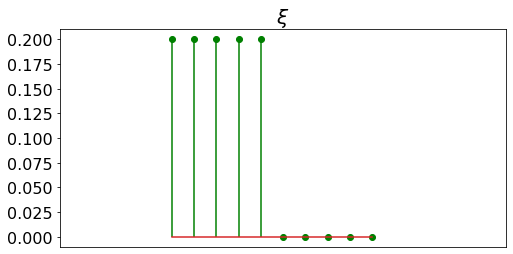

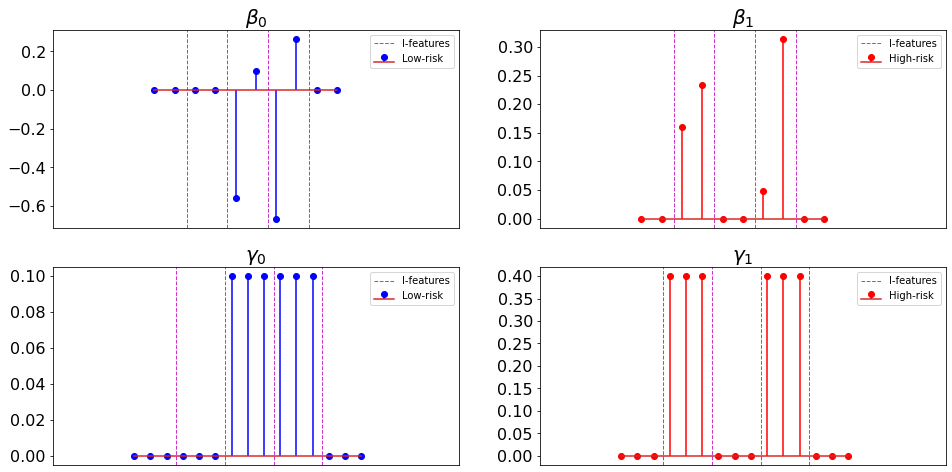

In [3]:
xi, betas, gammas = simu.time_indep_coeffs, simu.fixed_effect_coeffs, simu.asso_coeffs

fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(xi, linefmt='g-', markerfmt='go')
ax.set_xlim([-5, len(xi) + 5])
ax.set_title(r"$\xi$", fontsize=fontsize+4)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

fig = plt.figure(figsize=(16, 8))
names, colors, labels = ['beta', 'gamma'], ['b', 'r'], ['Low-risk', 'High-risk']
j = 1

for i, vectors in enumerate([betas, gammas]):
    for k in [0, 1]:
        name = names[i]
        ax = fig.add_subplot(2,2,j)
        j += 1
        ax.stem(vectors[k], linefmt='%s-' % colors[k], 
                markerfmt='%so' % colors[k], label=labels[k])
        ax.set_xlim([-5, len(vectors[k]) + 5])
        ax.set_title(r"$\%s_%s$" % (name, k), fontsize=fontsize+4)
        plt.yticks(fontsize=fontsize)
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
        plt.legend(fontsize=fontsize-2)
        visualize_vect_per_group(vectors[k], n_long_features, ax)
plt.show()

### Visualize simulated times

We choose a Gompertz distribution for the baseline, that is
$$\lambda_0(t) = \kappa_1 \kappa_2 \exp(\kappa_2t)$$
with $\kappa_1 > 0$ and $\kappa_2 \in R$ the scale and shape parameters respectively.

kappa_1=0.05, kappa_2=0.1


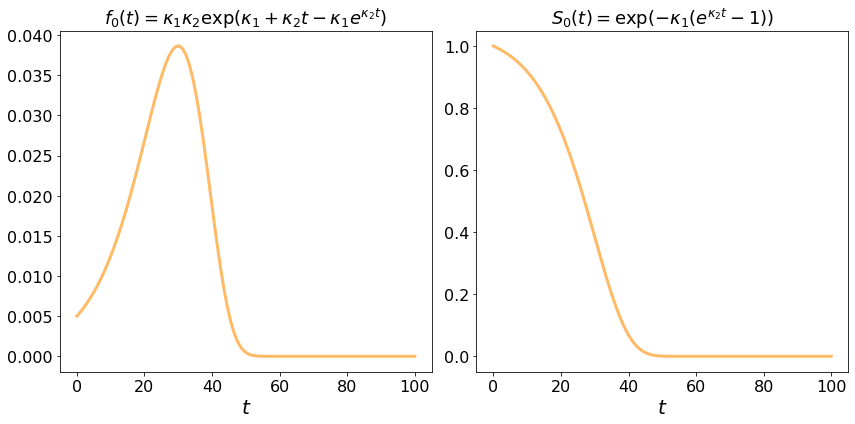

In [4]:
scale, shape = simu.scale, simu.shape
print("kappa_1=%s, kappa_2=%s" % (scale, shape))

fig = plt.figure(figsize=(12, 6))
# Density function plot
ax = fig.add_subplot(121)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_pdf(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$f_0(t) = \kappa_1 \kappa_2 \exp (\kappa_1 + \kappa_2 t -\kappa_1 e^{\kappa_2 t})$", 
          size=fontsize+2)

# Survival function plot
ax = fig.add_subplot(122)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_survival(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$S_0(t) = \exp (-\kappa_1 (e^{\kappa_2 t} - 1) )$", size=fontsize+2)

fig.tight_layout()
plt.show()

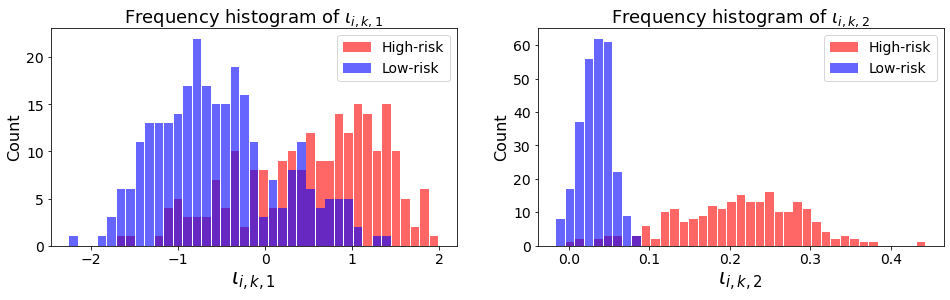

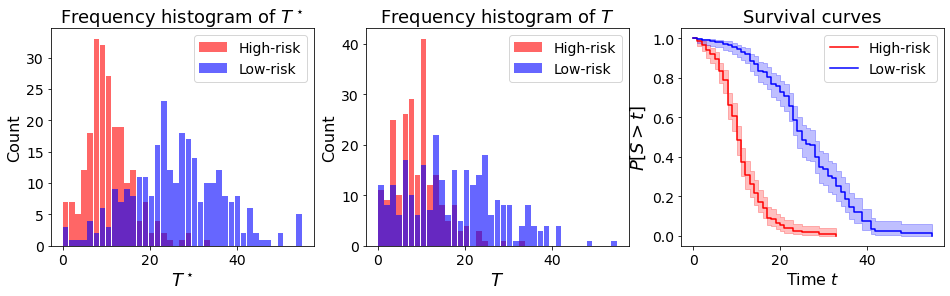

In [5]:
fig = plt.figure(figsize=(16, 4))
iotas = simu.iotas
for i in [1, 2]:
    ax = fig.add_subplot(1,2,i)
    iota_0i, iota_1i = iotas[i]
    all_iota = list(iota_0i) + list(iota_1i)
    mini, maxi = min(all_iota), max(all_iota)
    bins = np.linspace(mini, maxi, 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(iota_1i, **kwargs, color='r', label='High-risk')
    plt.hist(iota_0i, **kwargs, color='b', label='Low-risk')
    plt.xlabel(r"$\iota_{i,k,%s}$" % i, size=fontsize + 5)
    plt.ylabel("Count", size=fontsize)
    plt.legend(fontsize=fontsize-2)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$\iota_{i,k,%s}$' % i, size=fontsize+2)
plt.show()

fig = plt.figure(figsize=(16, 4))
G = simu.latent_class
T_star = simu.event_times
times, labels = [T_star, T], ['T^\star', 'T']
for i in [0, 1]:
    ax = fig.add_subplot(1,3,i+1)
    df = pd.DataFrame(data={"time": times[i], "group": G})
    bins = np.linspace(0, times[i].max(), 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(df.loc[df.group == 1, 'time'], **kwargs, color='r', label='High-risk')
    plt.hist(df.loc[df.group==0, 'time'], **kwargs, color='b', label='Low-risk')
    plt.legend(fontsize=fontsize-2)
    plt.xlabel(r'$%s$' % labels[i], size=fontsize+2)
    plt.ylabel("Count", size=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$%s$' % labels[i], size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(133)
kmf.fit(T[G == 1], delta[G == 1], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T[G == 0], delta[G == 0], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

### Visualize longitudinal processes for two subjects randomly chosen

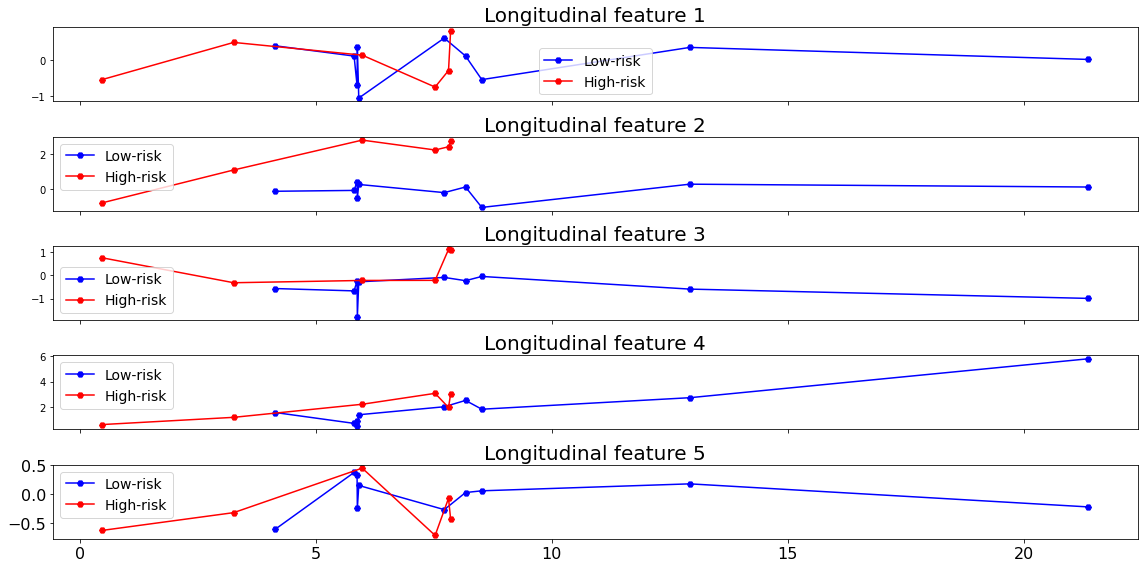

In [6]:
np.random.seed(10)
fig, ax = plt.subplots(n_long_features, 1, sharex=True, figsize=(16,8))
colors, labels = ['b', 'r'], ['Low-risk', 'High-risk']
idxs = [1, 0]
for k in [0, 1]:
    Y_i = Y[Y.id == idxs[k]]
    label, color = labels[k], colors[k]
    for l in range(1, n_long_features + 1):
        Y_il = Y_i[["T_long", "time_dep_feat%s" % l]]
        ax[l-1].plot(Y_il["T_long"], Y_il["time_dep_feat%s" % l], label=label, color=color, marker='H',)
        ax[l-1].set_title("Longitudinal feature %s" % l, fontsize=fontsize+4)
        plt.xticks(fontsize=fontsize), plt.yticks(fontsize=fontsize)
        ax[l-1].legend(fontsize=fontsize-2)
fig.tight_layout()
plt.show()

# Lights learning

## Initializer illustration

Since our QNMCEM algorithm gives a local minimum, it is clever to choose an initial value $\theta^{(0)}$ close to the final solution $\hat \theta$, so that the number of iterations required to reach convergence is reduced.

The longitudinal submodels parameters $\beta_k^{(0)}$, $D^{(0)}$ and $\phi^{(0)}$ are initialized (like if there is no subgroup ($\beta_0^{(0)} = \beta_{1}^{(0)}$)) using a multivariate linear mixed model (MLMM) with an explicit EM algorithm, being itself initialized with univariates fits (ULMM). Let us test those initializer on a simple example.

### Simulation with no latent subgroups

In [7]:
from lights.init.mlmm import MLMM
from lights.base.base import extract_features
from lights.base.utils import plot_history

# high_risk_rate=0 for no subgroups
simu_ = SimuJointLongitudinalSurvival(n_samples=200, n_time_indep_features=5, n_long_features=3, 
                                      seed=1, high_risk_rate=0, fixed_effect_mean_low_risk=(1., .3),
                                      cov_corr_long = .001, std_error = 2., sparsity=1, gap=1.)
Y_ = simu_.simulate()[1]
# Get true beta parameter
true_beta_ = simu_.fixed_effect_coeffs[0]

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 1.45e-01 seconds.


### MLMM with fixed initialization

For instance $\beta^{(0)}=\textbf{0}$

In [8]:
true_phi_ = simu_.std_error * np.ones((3, 1))
true_D_ = simu_.long_cov

Launching the solver MLMM...
 n_iter  |   obj    | rel_obj 
       0 |  6316.26 |      inf
       2 |  4965.07 | 2.14e-02
       4 |   4884.8 | 6.27e-03
       6 |  4847.63 | 3.27e-03
       8 |  4824.24 | 2.21e-03
      10 |   4806.4 | 1.76e-03
      12 |  4791.16 | 1.54e-03
      14 |  4777.19 | 1.44e-03
      16 |  4763.88 | 1.38e-03
      18 |  4750.94 | 1.35e-03
      20 |  4738.31 | 1.32e-03
      22 |  4726.18 | 1.27e-03
      24 |  4714.89 | 1.17e-03
      26 |  4704.94 | 1.01e-03
      28 |  4696.81 | 8.11e-04
      30 |  4690.75 | 5.90e-04
      32 |  4686.61 | 3.96e-04
      34 |  4683.92 | 2.55e-04
      36 |  4682.18 | 1.67e-04
      38 |  4680.98 | 1.17e-04
      40 |  4680.11 | 8.67e-05
      42 |  4679.44 | 6.78e-05
      44 |  4678.89 | 5.49e-05
      46 |  4678.45 | 4.56e-05
      48 |  4678.07 | 3.85e-05
      50 |  4677.75 | 3.31e-05
      52 |  4677.47 | 2.88e-05
      54 |  4677.23 | 2.53e-05
      56 |  4677.01 | 2.25e-05
      58 |  4676.82 | 2.01e-05
      60 |

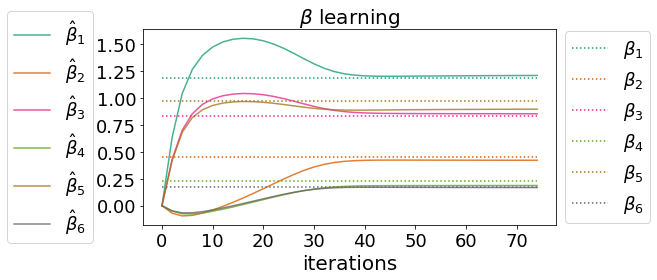

In [9]:
fixed_effect_time_order = 1
tol = 1e-5
mlmm = MLMM(print_every=2, fixed_effect_time_order=fixed_effect_time_order, 
            tol=tol, initialize=False, max_iter=300)
# Get design features matrices
extracted_features = extract_features(Y_, simu_.time_dep_feat, fixed_effect_time_order)
# Train the initializer
mlmm.fit(extracted_features)

# Visualize learning
to = len(true_beta_)+1
leg1 = [r"$\hat \beta_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta_%s$" % j for j in range(1, to)]
visualize_vect_learning(mlmm, "fixed_effect_coeffs", r"$\beta$", true_beta_, leg1, leg2)

### MLMM with ULMM initialization

<span style="color:crimson">**Convergence is faster, and the estimation much better**</span>

Launching the solver MLMM...
Launching the solver ULMM...
Done solving using ULMM in 9.12e-01 seconds
 n_iter  |   obj    | rel_obj 
       0 |  4715.79 |      inf
       5 |  4688.19 | 2.40e-04
      10 |  4684.46 | 1.20e-04
      15 |  4682.45 | 6.85e-05
      20 |  4681.23 | 4.37e-05
      25 |   4680.4 | 3.05e-05
      30 |   4679.8 | 2.30e-05
      35 |  4679.33 | 1.85e-05
      40 |  4678.94 | 1.57e-05
      45 |   4678.6 | 1.37e-05
      50 |   4678.3 | 1.24e-05
      55 |  4678.02 | 1.14e-05
      60 |  4677.77 | 1.06e-05
      65 |  4677.53 | 1.00e-05
Done solving using MLMM in 4.24e+00 seconds


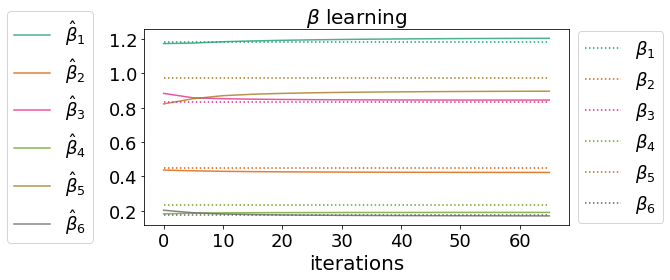

In [10]:
mlmm = MLMM(fixed_effect_time_order=fixed_effect_time_order, 
            print_every=5, tol=tol, initialize=True)
extracted_features = extract_features(Y_, simu_.time_dep_feat, fixed_effect_time_order)
mlmm.fit(extracted_features)
visualize_vect_learning(mlmm, "fixed_effect_coeffs", r"$\beta$", true_beta_, leg1, leg2)

In [11]:
# True covariance of random effect
true_long_cov = simu_.long_cov
print("True of covariance of random effect", true_long_cov)
# Estimation of covariance of random effect
est_long_cov = mlmm.long_cov
print("Estimatation of covariance of random effect", est_long_cov)

True of covariance of random effect [[1.e-02 1.e-03 1.e-06 1.e-09 1.e-12 1.e-15]
 [1.e-03 1.e-02 1.e-03 1.e-06 1.e-09 1.e-12]
 [1.e-06 1.e-03 1.e-02 1.e-03 1.e-06 1.e-09]
 [1.e-09 1.e-06 1.e-03 1.e-02 1.e-03 1.e-06]
 [1.e-12 1.e-09 1.e-06 1.e-03 1.e-02 1.e-03]
 [1.e-15 1.e-12 1.e-09 1.e-06 1.e-03 1.e-02]]
Estimatation of covariance of random effect [[ 0.25206336 -0.06291101  0.14620832 -0.0333244  -0.0489484   0.01478495]
 [-0.06291101  0.01885284 -0.0407444   0.00840625  0.01183058 -0.00307446]
 [ 0.14620832 -0.0407444   0.33898147 -0.09446729 -0.05215565  0.01454051]
 [-0.0333244   0.00840625 -0.09446729  0.03134143  0.01490335 -0.00280882]
 [-0.0489484   0.01183058 -0.05215565  0.01490335  0.14113091 -0.03876703]
 [ 0.01478495 -0.00307446  0.01454051 -0.00280882 -0.03876703  0.01503087]]


## Data splitting

In [12]:
# Split data into training and test sets 
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

data_index = np.unique(Y.id.values)
for train_index, test_index in rs.split(X):
    train_index = np.sort(train_index)
    test_index = np.sort(test_index)
    data_index_train = data_index[train_index]
    data_index_test = data_index[test_index]
    X_test = X[test_index]
    Y_test = Y[Y.id.isin(data_index_test)]
    T_test = T[test_index]
    delta_test = delta[test_index]
    
    X_train = X[train_index]
    Y_train = Y[Y.id.isin(data_index_train)]
    T_train = T[train_index]
    delta_train = delta[train_index]

print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


## Feature-screening

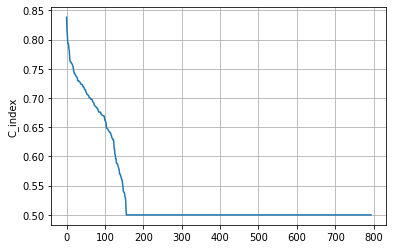

In [13]:
from tsfresh import extract_features as extract_rep_features
from sksurv.linear_model import CoxPHSurvivalAnalysis
from tsfresh.feature_extraction import ComprehensiveFCParameters

fc_parameters = ComprehensiveFCParameters()

y = np.zeros(len(T_train), dtype={'names':('indicator', 'time'), 'formats':('?', 'f8')})
y['indicator'] = delta_train
y['time'] = T_train
    
scores = {}
for key, val in fc_parameters.items():
    if val is not None:
        tmp = fc_parameters[key]
        score_tmp = []
        for val in tmp:
            feat = {key : [val]}
            ext_feat = extract_rep_features(Y_train, column_id="id",
                                                column_sort="T_long",
                                                default_fc_parameters=feat,
                                                impute_function=None,
                                                disable_progressbar=True
                                                )
            try:
                model = CoxPHSurvivalAnalysis().fit(ext_feat, y)
            except:
                score_tmp.append(0.5)
            else:
                score_tmp_ = model.score(ext_feat, y)
                score_tmp.append(max(score_tmp_, 1 - score_tmp_))
        scores[key] = score_tmp
    else:
        feat = {key : val}
        ext_feat = extract_rep_features(Y_train, column_id="id",
                                            column_sort="T_long",
                                            default_fc_parameters=feat,
                                            impute_function=None,
                                            disable_progressbar=True
                                            )
        try:
            model = CoxPHSurvivalAnalysis().fit(ext_feat, y)
        except:
            scores[key] = 0.5
        else:
            score_tmp_ = model.score(ext_feat, y)
            scores[key] = max(score_tmp_, 1 - score_tmp_)
        
flat_score = []
for item in list(scores.values()):
    if isinstance(item, list):
        flat_score += item
    else:
        flat_score += [item]

sorted_score = -np.sort(-np.array(flat_score))
plt.plot(sorted_score)
plt.ylabel("C_index")
plt.grid()
plt.show()

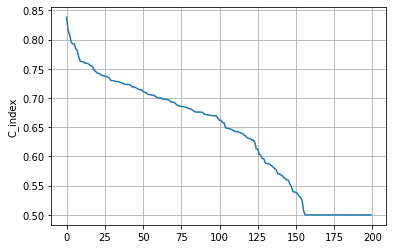

In [14]:
plt.plot(sorted_score[:200])
plt.ylabel("C_index")
plt.grid()
plt.show()

In [15]:
score_threshold = sorted_score[50]
selected_fc_parameters = {}
scores_ = {}
for key, val in fc_parameters.items():
    score = scores[key]
    if val is not None:
        tmp = []
        score_tmp = []
        for idx in range(len(score)):
            if score[idx] >= score_threshold:
                tmp.append(val[idx])
                score_tmp.append(score[idx])
        if tmp:
            selected_fc_parameters[key] = tmp
            scores_[key] = score_tmp
            
    else:
        if score >= score_threshold:
            selected_fc_parameters[key] = val
            scores_[key] = score

In [16]:
selected_fc_parameters

{'abs_energy': None,
 'standard_deviation': None,
 'variance': None,
 'root_mean_square': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'maximum': None,
 'absolute_maximum': None,
 'minimum': None,
 'cid_ce': [{'normalize': True}, {'normalize': False}],
 'quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
  {'f_agg': 'var', 'maxlag': 40}],
 'number_cwt_peaks': [{'n': 1}],
 'number_peaks': [{'n': 1}],
 'index_mass_quantile': [{'q': 0.1}, {'q': 0.2}, {'q': 0.3}, {'q': 0.4}],
 'cwt_coefficients': [{'widths': (2, 5, 10, 20), 'coeff': 0, 'w': 2}],
 'change_quantiles': [{'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8

## Remove correlation

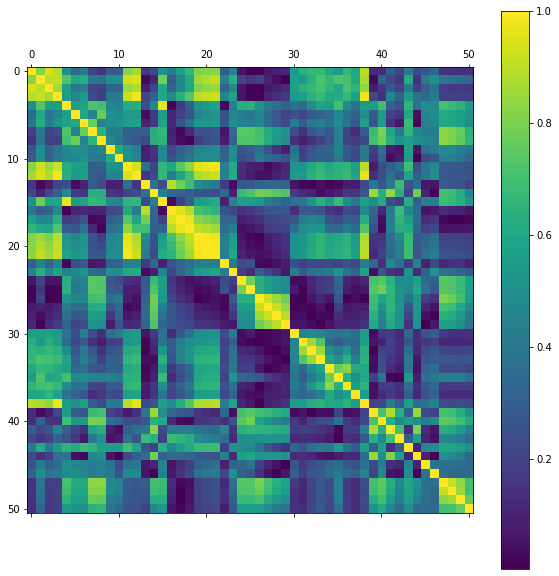

In [17]:
ext_feat = extract_rep_features(Y_train, column_id="id",
                                column_sort="T_long",
                                default_fc_parameters=selected_fc_parameters,
                                impute_function=None,
                                disable_progressbar=True
                                )
nb_extracted_feat = len(ext_feat.columns) // n_long_features
n_train_sample = ext_feat.shape[0]
ext_feat_df = ext_feat.values.reshape(n_train_sample, n_long_features, nb_extracted_feat)
ext_feat_df = ext_feat_df.T.reshape(nb_extracted_feat, -1).T
cor_matrix =  pd.DataFrame(ext_feat_df).corr().abs()
plt.figure(figsize=(10, 10))
plt.matshow(cor_matrix, fignum=1)
cb = plt.colorbar()
plt.show()

In [18]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
drop_columns = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

col_idx = 0
final_fc_parameters = {}
final_scores = {}
for key, val in selected_fc_parameters.items():
    score = scores_[key]
    if val is not None:
        tmp = []
        score_tmp = []
        for idx in range(len(val)):
            if col_idx not in drop_columns:
                tmp.append(val[idx])
                score_tmp.append(score[idx])
            col_idx += 1
        if tmp:
            final_fc_parameters[key] = tmp
            final_scores[key] = score_tmp
    else:
        if col_idx not in drop_columns:
            final_fc_parameters[key] = val
            final_scores[key] = score
        col_idx += 1

In [19]:
final_fc_parameters

{'abs_energy': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'minimum': None,
 'cid_ce': [{'normalize': True}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
  {'f_agg': 'var', 'maxlag': 40}],
 'number_cwt_peaks': [{'n': 1}],
 'number_peaks': [{'n': 1}],
 'index_mass_quantile': [{'q': 0.1}],
 'cwt_coefficients': [{'widths': (2, 5, 10, 20), 'coeff': 0, 'w': 2}],
 'change_quantiles': [{'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}],
 'range_count': [{'min': -1000000000000.0, 'max': 0},
  {'min': 0, 'max': 1000000000000.0}],
 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 8},
  {'num_segments'

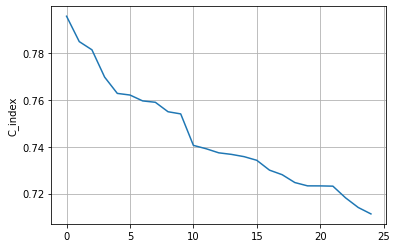

In [20]:
flat_score = []
for item in list(final_scores.values()):
    if isinstance(item, list):
        flat_score += item
    else:
        flat_score += [item]

sorted_score = -np.sort(-np.array(flat_score))
plt.plot(sorted_score)
plt.ylabel("C_index")
plt.grid()
plt.show()

In [21]:
score_threshold = sorted_score[9]
final_selected_fc_parameters = {}
scores_ = {}
for key, val in final_fc_parameters.items():
    score = final_scores[key]
    if val is not None:
        tmp = []
        score_tmp = []
        for idx in range(len(score)):
            if score[idx] >= score_threshold:
                tmp.append(val[idx])
                score_tmp.append(score[idx])
        if tmp:
            final_selected_fc_parameters[key] = tmp
            scores_[key] = score_tmp
            
    else:
        if score >= score_threshold:
            final_selected_fc_parameters[key] = val
            scores_[key] = score

In [22]:
final_selected_fc_parameters

{'abs_energy': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'cid_ce': [{'normalize': True}],
 'agg_autocorrelation': [{'f_agg': 'var', 'maxlag': 40}],
 'range_count': [{'min': -1000000000000.0, 'max': 0},
  {'min': 0, 'max': 1000000000000.0}],
 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 9}]}

## Cross-validation

In [ ]:
from lights.cross_val import cross_validate
fixed_effect_time_order = 1
best_param, trials = cross_validate(X_train, Y_train, T_train, delta_train, 
                                    final_fc_parameters, fixed_effect_time_order,
                                    adaptative_grid_el=True,
                                    n_folds=3, zeta_gamma_max=1, zeta_xi_max = 1,
                                    max_iter=10, max_iter_lbfgs=50,
                                    max_iter_proxg=10, max_eval=5, sparsity=sparsity)

In [ ]:
# visualize the contour of cross-validation process
def unpack(x):
    if x:
        return x[0]
    return np.nan
trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in trials])
trials_df["loss"] = [t["result"]["loss"] for t in trials]
trials_df["trial_number"] = trials_df.index

fig = go.Figure(
    data=go.Contour(
        z=trials_df["loss"],
        x=trials_df["l_pen_EN"],
        y=trials_df["l_pen_SGL"],
        contours=dict(
            showlabels=True,  # show labels on contours
            labelfont=dict(size=12, color="white",),  # label font properties
        ),
        colorbar=dict(title="loss", titleside="right",),
        hovertemplate="loss: %{z}<br>l_pen_EN: %{x}<br>l_pen_SGL: %{y}<extra></extra>",
    )
)

fig.update_layout(
    xaxis_title="log_l_pen_EN",
    yaxis_title="log_l_pen_SGL",
    title={
        "text": "l_pen_EN vs. l_pen_SGL",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
    },
)

fig.add_trace(
    go.Scatter(
        mode='markers',
        x=[best_param["l_pen_EN"]],
        y=[best_param["l_pen_SGL"]],
        marker=dict(
            color='Red',
            size=10
        ),
        text = "Best parameter"
    )
)
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")

## Training 

Launching the solver prox_QNEM...
Launching the solver MLMM...
Launching the solver ULMM...
Done solving using ULMM in 9.46e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  12692.3 |      inf
       1 |  11821.2 | 6.86e-02
       2 |  11566.5 | 2.15e-02
       3 |  11448.9 | 1.02e-02
       4 |  11381.2 | 5.92e-03
       5 |  11337.8 | 3.81e-03
       6 |  11308.3 | 2.60e-03
       7 |  11287.3 | 1.85e-03
       8 |  11271.9 | 1.36e-03
       9 |  11260.3 | 1.03e-03
      10 |  11251.4 | 7.96e-04
      11 |  11244.3 | 6.27e-04
      12 |  11238.7 | 5.03e-04
      13 |  11234.1 | 4.09e-04
      14 |  11230.3 | 3.37e-04
      15 |  11227.1 | 2.81e-04
      16 |  11224.5 | 2.37e-04
      17 |  11222.2 | 2.02e-04
      18 |  11220.3 | 1.73e-04
      19 |  11218.6 | 1.49e-04
      20 |  11217.1 | 1.30e-04
Done solving using MLMM in 1.58e+01 seconds
 n_iter  |   obj    | rel_obj 
       0 |  47.4258 |      inf
       1 |  36.6408 | 2.27e-01
       2 |  35.2745 | 3.73e-02
       3 |  34

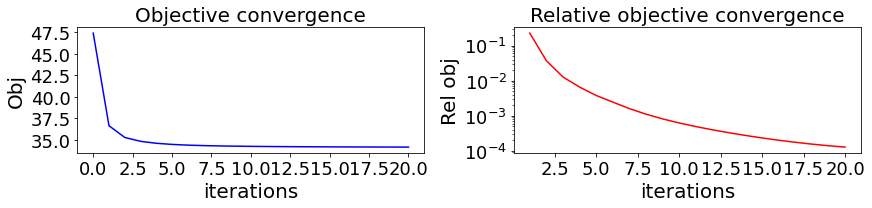

In [23]:
from lights.inference import prox_QNEM

## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'

#l_pen_EN, l_pen_SGL = best_param.values()
# Training with hyper-params set manually
l_pen_EN, l_pen_SGL = .02, .98
eta_sp_gp_l1 = .97
fixed_effect_time_order = 1
eta_elastic_net = .1
learner = prox_QNEM(fixed_effect_time_order=fixed_effect_time_order, max_iter=20, print_every=1,
               l_pen_SGL=l_pen_SGL, l_pen_EN=l_pen_EN, eta_sp_gp_l1 = eta_sp_gp_l1, initialize=True, 
                fc_parameters=final_selected_fc_parameters, sparsity=sparsity, 
                   eta_elastic_net=eta_elastic_net)
learner.fit(X_train, Y_train, T_train, delta_train)

# Visualize learning
visualize_vect_learning(learner, "obj")

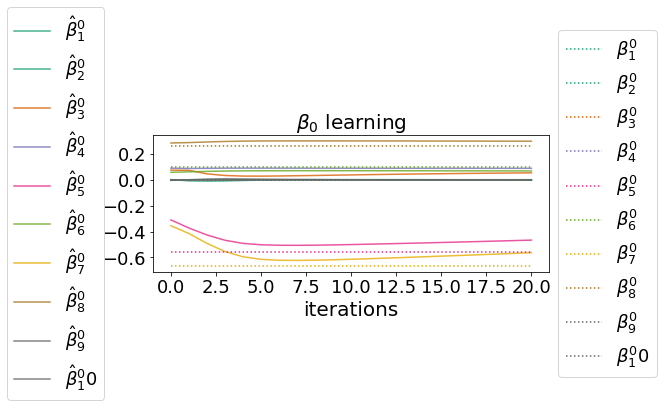

In [24]:
# Visualize beta_0
true_beta_0 = simu.fixed_effect_coeffs[0].reshape(-1, 1)
to = len(true_beta_0)+1
leg1 = [r"$\hat \beta^0_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^0_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "beta_0", r"$\beta_0$", true_beta_0, leg1, leg2)

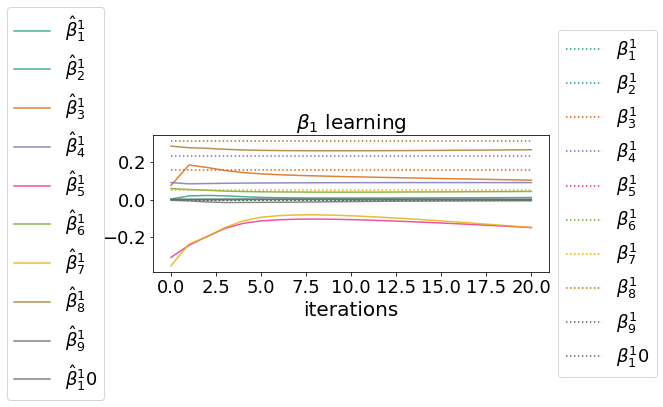

In [25]:
# Visualize beta_1
true_beta_1 = simu.fixed_effect_coeffs[1].reshape(-1, 1)
to = len(true_beta_1)+1
leg1 = [r"$\hat \beta^1_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^1_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "beta_1", r"$\beta_1$", true_beta_1, leg1, leg2)

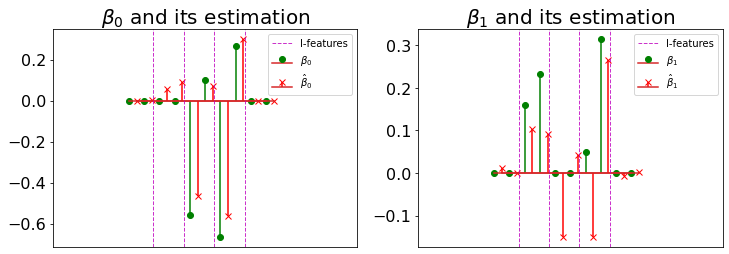

In [26]:
beta_0_true = true_beta_0
beta_0_est = learner.theta["beta_0"]
fig = plt.figure(figsize=(12, 4))
fontsize = 16
ax = fig.add_subplot(121)
ax.stem(np.arange(len(beta_0_true)).tolist(), beta_0_true, linefmt='g-', markerfmt='go', label= r"$\beta_0$")
ax.stem((np.arange(len(beta_0_est)) + .5).tolist(), beta_0_est, linefmt='r-', markerfmt='rx', label= r"$\hat \beta_0$")
ax.set_xlim([-5, len(beta_0_true) + 5])
ax.set_title(r"$\beta_0$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(beta_0_true, n_long_features, ax)

beta_1_true = true_beta_1
beta_1_est = learner.theta["beta_1"]
fontsize = 16
ax = fig.add_subplot(122)
ax.stem(np.arange(len(beta_1_true)).tolist(), beta_1_true, linefmt='g-', markerfmt='go', label= r"$\beta_1$")
ax.stem((np.arange(len(beta_1_est)) + .5).tolist(), beta_1_est, linefmt='r-', markerfmt='rx', label= r"$\hat \beta_1$")
ax.set_xlim([-5, len(beta_1_true) + 5])
ax.set_title(r"$\beta_1$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(beta_1_true, n_long_features, ax)
plt.show()

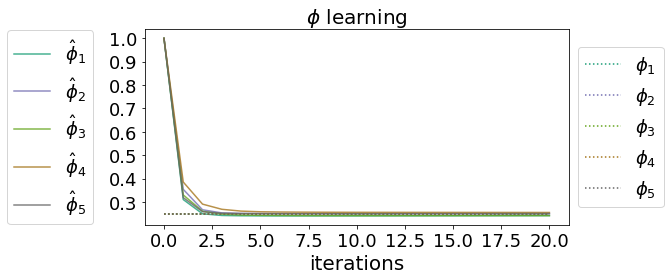

In [27]:
# Visualize phi
true_phi = np.array([simu.std_error ** 2] * simu.n_long_features).reshape(-1, 1)
to = len(true_phi)+1
leg1 = [r"$\hat \phi_%s$" % j for j in range(1, to)]
leg2 = [r"$\phi_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "phi", symbol = r"$\phi$", true_coeffs = true_phi, legend_est = leg1, legend_true = leg2)

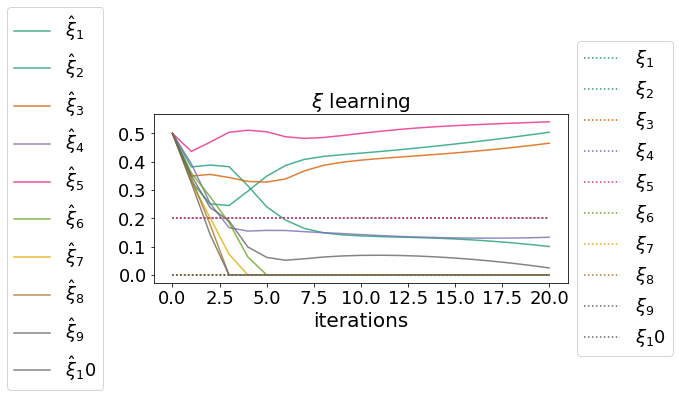

In [28]:
# Visualize xi
true_xi = simu.time_indep_coeffs.reshape(-1, 1)
to = len(true_xi)+1
leg1 = [r"$\hat \xi_%s$" % j for j in range(1, to)]
leg2 = [r"$\xi_%s$" % j for j in range(1, to)]
visualize_vect_learning(learner, "xi", r"$\xi$", true_xi, leg1, leg2)

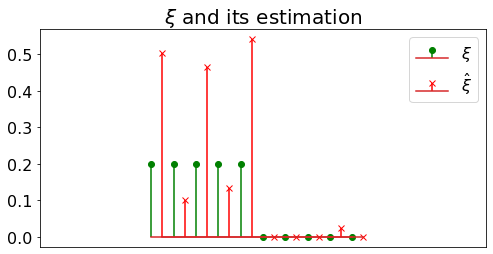

In [29]:
xi_true = true_xi
xi_est = learner.theta["xi"]
fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(np.arange(len(xi_true)).tolist(), true_xi, linefmt='g-', markerfmt='go', label= r"$\xi$")
ax.stem((np.arange(len(xi_est)) + .5).tolist(), xi_est, linefmt='r-', markerfmt='rx', label= r"$\hat \xi$")
ax.set_xlim([-5, len(true_xi) + 5])
ax.set_title(r"$\xi$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

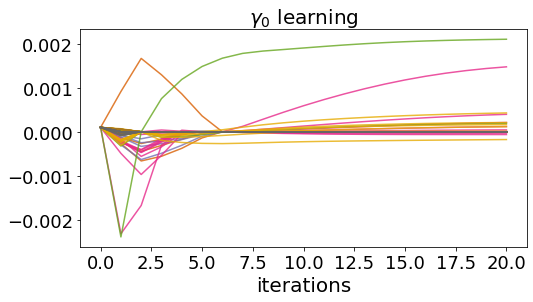

In [30]:
# Visualize gamma_0
to = len(learner.theta["gamma_0"])+1
leg1 = [r"$\hat \gamma^0_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^0_{%s}$" % j for j in range(1, to)]
visualize_vect_learning(learner, "gamma_0", r"$\gamma_0$", leg1, leg2)

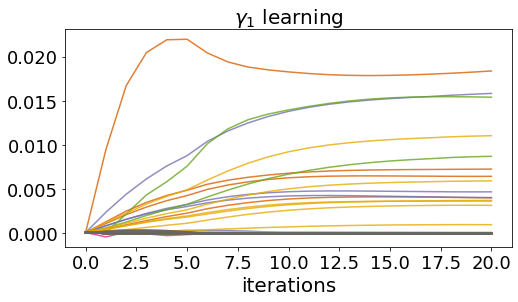

In [31]:
# Visualize gamma_1
to = len(learner.theta["gamma_1"])+1
leg1 = [r"$\hat \gamma^1_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^1_{%s}$" % j for j in range(1, to)]
visualize_vect_learning(learner, "gamma_1", r"$\gamma_1$", leg1, leg2)

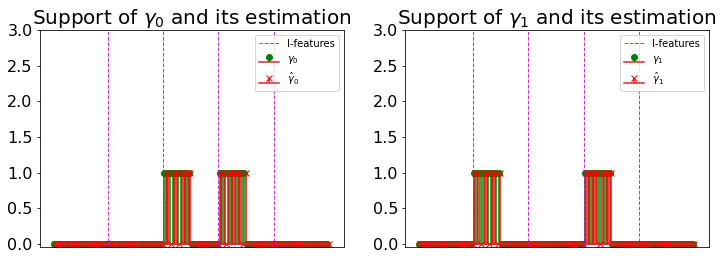

In [32]:
L = Y.shape[1] - 2
S_k = simu.S_k
nb_asso_param = learner.theta["gamma_0"].flatten().shape[0] // L
nb_extracted_feat_param = learner.nb_extracted_feat
nb_noise_param = nb_asso_param - nb_extracted_feat_param
gamma_0_true_support = []
for l in range(L):
    if l in S_k[0]:
        gamma_0_true_support += [0] * nb_asso_param 
    else:
        gamma_0_true_support += [1] *  nb_extracted_feat_param + [0] * nb_noise_param
gamma_0_est_support = (learner.theta["gamma_0"].copy() != 0).astype(int)
gamma_0_true_support = np.array(gamma_0_true_support)
fig = plt.figure(figsize=(12, 4))
fontsize = 16
ax = fig.add_subplot(121)
ax.stem(np.arange(len(gamma_0_true_support)).tolist(), gamma_0_true_support, linefmt='g-', markerfmt='go', label= r"$\gamma_0$")
ax.stem((np.arange(len(gamma_0_est_support)) + .5).tolist(), gamma_0_est_support, linefmt='r-', markerfmt='rx', label= r"$\hat \gamma_0$")
ax.set_xlim([-5, len(gamma_0_true_support) + 5])
ax.set_title(r"Support of $\gamma_0$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(-0.05, 3)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(gamma_0_true_support, n_long_features, ax)

gamma_1_true_support = []
for l in range(L):
    if l in S_k[1]:
        gamma_1_true_support += [0] * nb_asso_param
    else:
        gamma_1_true_support += [1] *  nb_extracted_feat_param + [0] * nb_noise_param
gamma_1_est_support = (learner.theta["gamma_1"].copy() != 0).astype(int)
gamma_1_true_support = np.array(gamma_1_true_support)
ax = fig.add_subplot(122)
ax.stem(np.arange(len(gamma_1_true_support)).tolist(), gamma_1_true_support, linefmt='g-', markerfmt='go', label= r"$\gamma_1$")
ax.stem((np.arange(len(gamma_1_est_support)) + .5).tolist(), gamma_1_est_support, linefmt='r-', markerfmt='rx', label= r"$\hat \gamma_1$")
ax.set_xlim([-5, len(gamma_1_true_support) + 5])
ax.set_title(r"Support of $\gamma_1$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(-0.05, 3)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
visualize_vect_per_group(gamma_1_true_support, n_long_features, ax)
plt.show()

<AxesSubplot:>

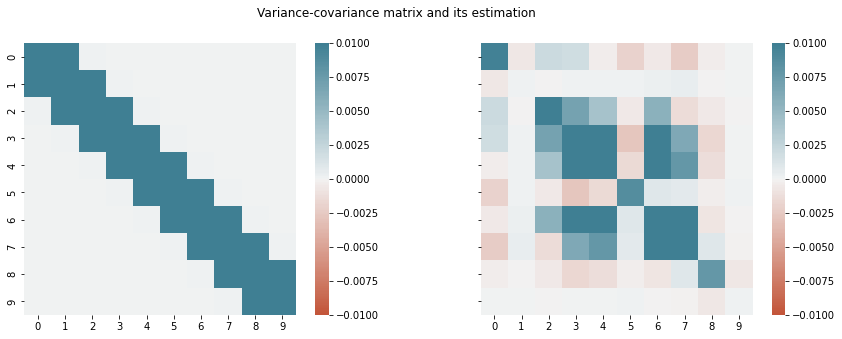

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Variance-covariance matrix and its estimation')

sns.heatmap(
    data=simu.long_cov, 
    vmin=-.01, vmax=.01, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=axes[0]
)

sns.heatmap(
    data=learner.theta["long_cov"], 
    vmin=-.01, vmax=.01, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=axes[1]
)

<function matplotlib.pyplot.show(close=None, block=None)>

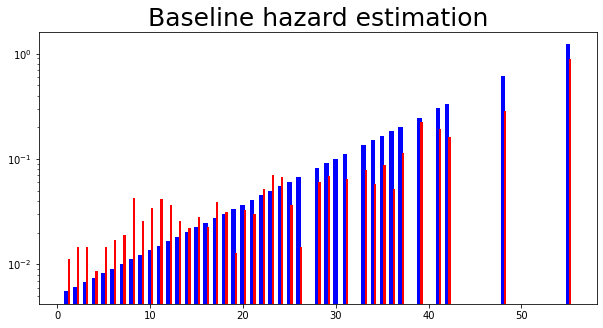

In [35]:
times = learner.theta["baseline_hazard"].index.values
est_value = learner.theta["baseline_hazard"].values
true_value = (simu.scale * simu.shape) * np.exp(simu.shape * times)
non_zero_idx = np.argwhere(est_value != 0)
fig = plt.figure(figsize=(10, 5))
plt.bar(times, true_value, color = 'b', width = 0.5)
plt.bar(times + 0.25, est_value, color = 'r', width = 0.25)
plt.title("Baseline hazard estimation", fontsize=25)
plt.yscale('log')
plt.show

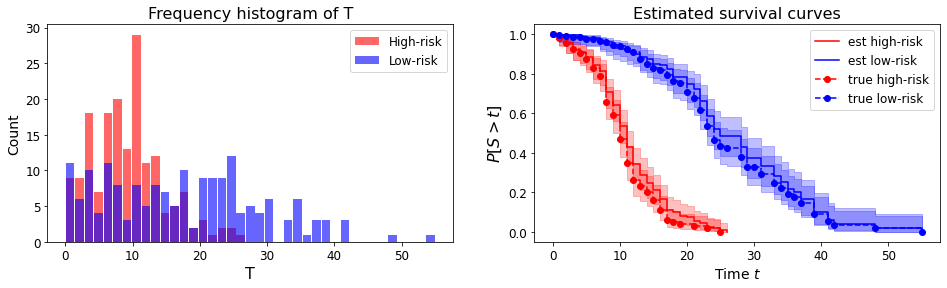

In [36]:
G_train = simu.latent_class[train_index]
# estimation of G
est_G = (learner.pi_est > .5).astype(int)
fig = plt.figure(figsize=(16, 4))
fontsize = 14
ax = fig.add_subplot(1,2,1)
bins = np.linspace(0, T_train.max(), 40)
kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
plt.hist(T_train[est_G == 1], **kwargs, color='r', label='High-risk')
plt.hist(T_train[est_G == 0], **kwargs, color='b', label='Low-risk')
plt.legend(fontsize=fontsize-2)
plt.xlabel("T", size=fontsize+2)
plt.ylabel("Count", size=fontsize)
ax.tick_params(labelsize=fontsize-2)
plt.title("Frequency histogram of T", size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(122)
kmf.fit(T_train[est_G == 1], delta_train[learner.pi_est > .5], label="est high-risk").plot(ax=ax, c='r')
kmf.fit(T_train[est_G == 0], delta_train[learner.pi_est < .5], label="est low-risk").plot(ax=ax, c='b')
kmf.fit(T_train[G_train == 1], delta_train[G_train == 1], label="true high-risk").plot(ax=ax, c='r', marker='o', linestyle='dashed')
kmf.fit(T_train[G_train == 0], delta_train[G_train == 0], label="true low-risk").plot(ax=ax, c='b', marker='o', linestyle='dashed')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

## Visualize pi_est

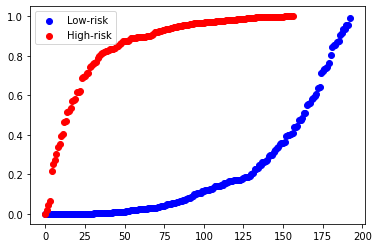

In [37]:
n1 = sum(G_train)
n0 = len(G_train) - n1
plt.scatter(np.arange(n0), np.sort(learner.pi_est[G_train == 0]), c='b', label="Low-risk")
plt.scatter(np.arange(n1), np.sort(learner.pi_est[G_train == 1]), c='r', label="High-risk")
plt.legend()
plt.show()

## Prediction

In [38]:
# evalutation here
c_index_train = learner.score(X_train, Y_train, T_train, delta_train)

## Obtain the marker vector on test set ##

# prediction here
c_index_test = learner.score(X_test, Y_test, T_test, delta_test)

print("Done predicting on dataset.")
print("C-index on train: %.2f" % c_index_train)
print("C-index on test: %.2f" % c_index_test)

Done predicting on dataset.
C-index on train: 0.77
C-index on test: 0.80


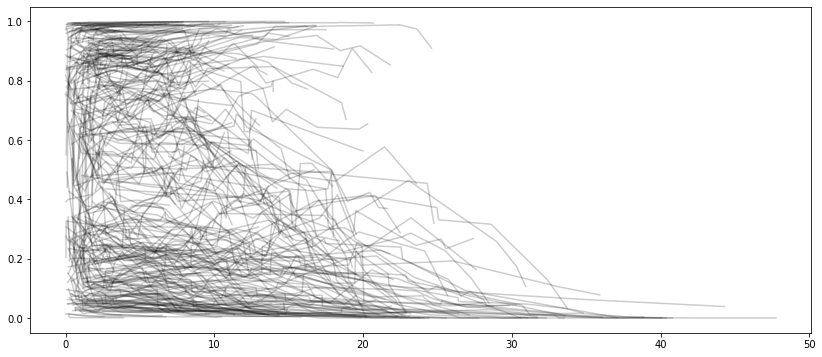

In [39]:
marker_pred = learner.predict_marker_sample(X_train, Y_train)
plt.figure(figsize=(14, 6))
id_list = list(np.unique(Y_train.id.values))
for i in range(len(marker_pred)):
    t_ = Y[(Y["id"] == id_list[i])]["T_long"].values
    plt.plot(t_, marker_pred[i], 'k', alpha=0.2)
plt.show()

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 1.45e+00 seconds.


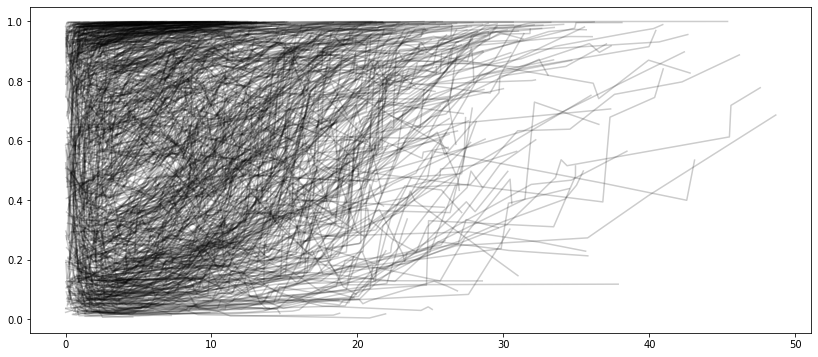

In [43]:
simu.n_samples=1000
X_new, Y_new, T_new, delta_new = simu.simulate()
marker_pred = learner.predict_marker_sample(X_new, Y_new)
plt.figure(figsize=(14, 6))
id_list = list(np.unique(Y_new.id.values))
for i in range(len(marker_pred)):
    t_ = Y_new[(Y_new["id"] == id_list[i])]["T_long"].values
    plt.plot(t_, marker_pred[i], 'k', alpha=0.2)
plt.show()

## Figures

### Learning curves

### Convergence

### Beta coefficients